# O ambiente

In [ ]:
import gfootball.env as football_env

env = football_env.create_environment(env_name="academy_empty_goal", representation="pixels", render=True)

In [9]:
state_dims  = env.observation_space.shape
state_dims

(72, 96, 3)

In [11]:
n_actions = env.action_space.n
n_actions

19

# Tomando Uma ação

In [6]:
env.action_space.sample()

18

In [2]:
obs, reward, done, info = env.step(env.action_space.sample())
print(reward)
print(done)
print(info)
print(obs)

0.0
False
{'score_reward': 0}
[[[101 126  82]
  [101 125  81]
  [102 126  82]
  ...
  [ 94 119  77]
  [ 93 116  76]
  [ 92 115  75]]

 [[102 129  80]
  [104 130  81]
  [105 131  82]
  ...
  [ 95 121  75]
  [ 93 119  74]
  [ 91 116  73]]

 [[102 130  79]
  [104 131  80]
  [103 130  80]
  ...
  [ 94 121  74]
  [ 93 119  73]
  [ 91 116  72]]

 ...

 [[ 70 100  46]
  [ 71 100  47]
  [ 71 100  46]
  ...
  [ 85 115  57]
  [ 86 115  57]
  [ 84 114  57]]

 [[ 69  98  45]
  [ 70  97  45]
  [ 69  96  44]
  ...
  [ 84 113  56]
  [ 85 114  57]
  [ 85 116  58]]

 [[ 70  98  46]
  [ 70  98  45]
  [ 71  99  46]
  ...
  [ 83 113  55]
  [ 83 112  56]
  [ 85 116  58]]]


In [ ]:
#rodando o jogo
ppo_steps = 128

for i in range(ppo_steps):
    obs, reward, done, info = env.step(env.action_space.sample())
    if done:
        env.reset()

# Usando uma rede Actor

In [ ]:
import keras.backend as K
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import MobileNetV2
import numpy as np


def get_model_actor_image(input_dims):
    state_input = Input(shape=input_dims)
    feature_extractor = MobileNetV2(weights="imagenet", include_top=False)
    # nao treinar esse feature extractor
    for layer in feature_extractor.layers:
        layer.trainable = False

    x = Flatten(name="flatten")(feature_extractor(state_input))
    x = Dense(1024, activation='relu', name='fc1')(x)
    out_actions = Dense(n_actions, activation='softmax', name='predictions')(x)

    model = Model(inputs=[state_input], outputs=[out_actions])
    model.compile(optimizer = Adam(lr=1e-4), loss='ms   e')
    
    return model

In [ ]:
env = football_env.create_environment(env_name="academy_empty_goal", representation="pixels", render=True)

n_actions = env.action_space.n
state_dims = env.observation_space.shape

state = env.reset()

In [ ]:
actor_model = get_model_actor_image(input_dims=state_dims)

for i in range(ppo_steps):
    state_input = K.expand_dims(state, 0)
    # prever a distribuicao de ações (politica), e escolher uma da distribuicao
    action_dist = actor_model.predict([state_input], steps=1)
    action = np.random.choice(n_actions, p=action_dist[0, :])
    action_one_hot = np.zeros(n_actions)
    action_one_hot[action] = 1

    obs, reward, done, info = env.step(env.action_space.sample())
    if done:
        env.reset()

env.close()

# Actor-Critic

In [ ]:
def get_model_critic_image(input_dims):
    state_input = Input(shape=input_dims)
    feature_extractor = MobileNetV2(weights="imagenet", include_top=False)
    # nao treinar esse feature extractor
    for layer in feature_extractor.layers:
        layer.trainable = False

    x = Flatten(name="flatten")(feature_extractor(state_input))
    x = Dense(1024, activation='relu', name='fc1')(x)
    #mudamos para apenas o output, 1 valor real que indica a qualidade do estado acessado
    out_actions = Dense(1, activation='tanh', name='predictions')(x)

    model = Model(inputs=[state_input], outputs=[out_actions])
    model.compile(optimizer = Adam(lr=1e-4), loss='ms   e')
    
    return model

In [ ]:
actor_model = get_model_actor_image(input_dims=state_dims)
critic_model = get_model_critic_image(input_dims=state_dims)

states = []
actions = []
values = []
masks = [] # verifica se jogo terminou
rewards = []
actions_probs = []
actions_onehot = []

for i in range(ppo_steps):
    state_input = K.expand_dims(state, 0)
    # prever a distribuicao de ações (politica), e escolher uma acao da distribuicao
    action_dist = actor_model.predict([state_input], steps=1)
    action = np.random.choice(n_actions, p=action_dist[0, :])
    action_one_hot = np.zeros(n_actions)
    action_one_hot[action] = 1

    q_value = critic_model.predict([state_input], steps=1)

    obs, reward, done, info = env.step(env.action_space.sample())
    masks = not done

    states.append(state)
    actions.append(action)
    actions_onehot.append(action_one_hot)
    values.append(q_value)
    rewards.append(reward)
    actions_probs.append(action_dist)

    # altera o estado para a nova observação
    state = obs

    if done:
        env.reset()

env.close()

# Calculando vantagem

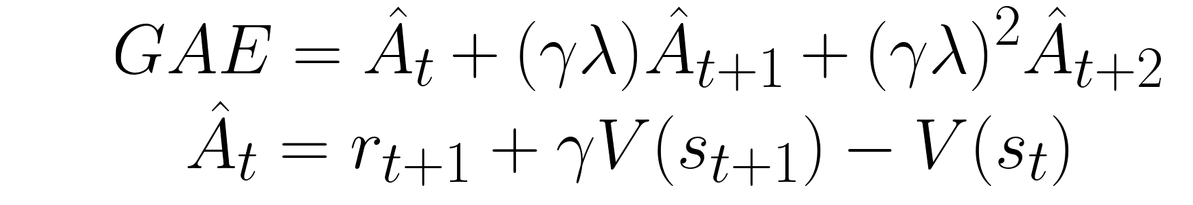

In [ ]:

def get_advantage(values, masks, rewards):
    returns = []
    gae = 0

    # seguindo a formula para gae
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma*values[i+1] *masks[i] - values[i]
        gae = delta + gamma*lambda_* masks[i]*gae

        return_i = gae + values[i]
        returns.insert(0, return_i)

    advantage = np.array(returns) - values[:1]
    # normalizando
    advantage = (advantage - np.mean(advantage))/(np.std(advantage) + 1e-10)

    return returns, advantage


In [ ]:

ppo_steps = 128
gamma = 0.99
lambda_ = 0.95


actor_model = get_model_actor_image(input_dims=state_dims)
critic_model = get_model_critic_image(input_dims=state_dims)

states = []
actions = []
values = []
masks = [] # verifica se jogo terminou
rewards = []
actions_probs = []
actions_onehot = []

for i in range(ppo_steps):
    state_input = K.expand_dims(state, 0)

    # prever a distribuicao de ações (politica), e escolher uma acao da distribuicao
    action_dist = actor_model.predict([state_input], steps=1)
    action = np.random.choice(n_actions, p=action_dist[0, :])
    action_one_hot = np.zeros(n_actions)
    action_one_hot[action] = 1

    q_value = critic_model.predict([state_input], steps=1)

    obs, reward, done, info = env.step(env.action_space.sample())
    masks = not done

    # Registra
    states.append(state)
    actions.append(action)
    actions_onehot.append(action_one_hot)
    values.append(q_value)
    rewards.append(reward)
    actions_probs.append(action_dist)

    # altera o estado para a nova observação
    state = obs

    if done:
        env.reset()

#mais um registro pro q_value
state_input = K.expand_dims(state, 0)
q_value = critic_model.predict([state_input], steps=1)
values.append(q_value)

returns, advantages = get_advantage(values, masks, rewards)


env.close()

# A função de loss

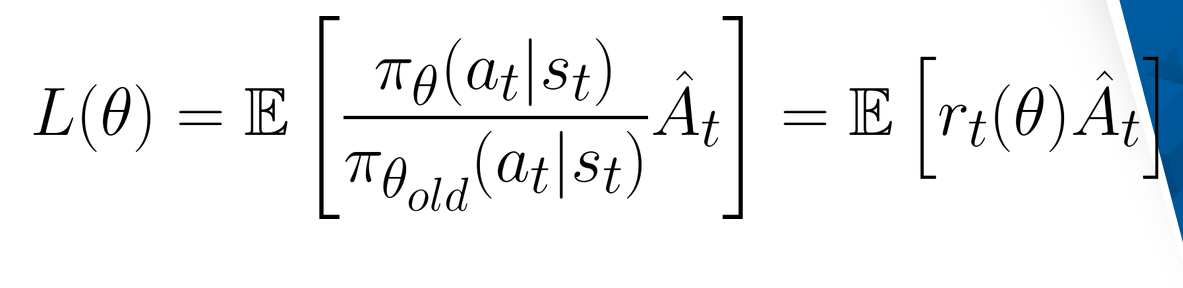

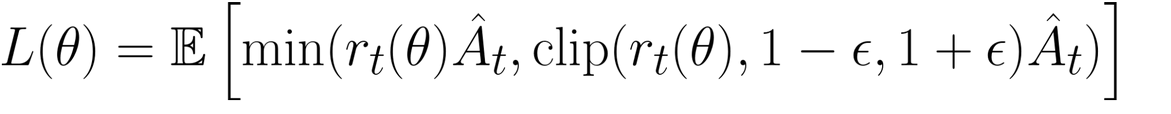

In [ ]:
clip_param = 0.2
critic_discount = 0.5
entropy_beta = 0.001


def get_ppo_loss(oldpolicy_probs, advantages, rewards, values):
    def loss(y_true, y_pred):
        newpolicy_probs = y_pred
        ratio = K.exp(K.log(newpolicy_probs + 1e-10) - K.log(oldpolicy_probs + 1e-10))

        p1 = ratio*advantages
        p2 = K.clip(ratio, min_value= 1 - clip_param, max_value= 1 + clip_param) * advantages

        actor_loss = -K.mean(K.minimum(p1,p2))
        critic_loss = K.mean(K.square(rewards-values))

        total_loss = critic_discount * critic_loss + actor_loss - entropy_beta * K.mean(-(newpolicy_probs*K.log(newpolicy_probs + 1e-10)))
        
        return total_loss
    
    return loss